# AIF Example Workflow

This notebook demonstrates what the **Automated Interpretation Framework (AIF)** does: it evaluates multiple phase interpretations for an XRD pattern by combining four key metrics, then displays the results and plots.

**Run this notebook from the project root** (e.g. `jupyter notebook notebooks/AIF_example_workflow.ipynb` from the repo root).

## 1. Setup and load data

In [24]:
import sys
import json
from pathlib import Path

import pandas as pd

# Add src to path
ROOT = Path.cwd()
if (ROOT / "notebooks").exists():
    ROOT = ROOT  # cwd is project root
else:
    ROOT = ROOT.parent  # cwd is notebooks/
SRC = ROOT / "src"
sys.path.insert(0, str(SRC))

# Output directory for plots (inside notebooks for easy display)
OUTPUT_DIR = ROOT / "notebooks" / "example_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load interpretations and synthesis data
INTERP_PATH = ROOT / "data" / "xrd_data" / "interpretations" / "interpretations.json"
CSV_PATH = ROOT / "data" / "xrd_data" / "synthesis_data.csv"

with open(INTERP_PATH) as f:
    all_interpretations = json.load(f)

df = pd.read_csv(CSV_PATH)


SAMPLE_KEY = "TRI_114"
interpretations = all_interpretations[SAMPLE_KEY]
filtered_df = df[df["Name"].str.contains(rf'^{SAMPLE_KEY}$', na=False)]
if filtered_df.empty:
    filtered_df = df[df["Name"].str.contains(rf'^{SAMPLE_KEY.replace("_", "-")}$', na=False)]
target = filtered_df["Target"].iloc[0]
precursors = filtered_df["Precursors"].iloc[0]
temp = filtered_df["Temperature (C)"].iloc[0]
dwell = filtered_df["Dwell Duration (h)"].iloc[0]
furnace = filtered_df["Furnace"].iloc[0]

print(f"Sample: {SAMPLE_KEY}")
print(f"Target phase: {target}")
print(f"\nSynthesis conditions:")
print(f"  Precursors: {precursors}")
print(f"  Temperature: {temp}°C")
print(f"  Dwell time: {dwell} hours")
print(f"  Furnace: {furnace}")
print(f"\nInterpretations: {list(interpretations.keys())}")

Sample: TRI_114
Target phase: LiVO2

Synthesis conditions:
  Precursors: ['Li2CO3', 'V2O5']
  Temperature: 600°C
  Dwell time: 12.0 hours
  Furnace: TF-Ar + H2

Interpretations: ['I_1', 'I_2', 'I_3', 'I_4', 'I_5']


## 2. The four metrics

Each interpretation is scored using four metrics that feed into the posterior probability:

### 2.1 Composition balance score

Measures how well the combined phase composition matches the target composition from synthesis. A score of 1 means a perfect match; lower scores indicate missing elements, extra elements, or stoichiometry mismatches.

In [25]:
from IPython.display import display, HTML

print("=" * 70)
print("COMPOSITION BALANCE SCORE (0–1, higher = better match)")
print("=" * 70)
for key, data in interpretations.items():
    bal = data.get("balance_score", 0)
    val = bal if bal is not None else 0
    phases = ", ".join(data.get("phases", []))
    print(f"\n{key}: {val:.3f}")
    print(f"  Phases: {phases}")

COMPOSITION BALANCE SCORE (0–1, higher = better match)

I_1: 0.964
  Phases: Li3VO4_31, V2O3_167, V4O7_2

I_2: 0.980
  Phases: Li3VO4_31, V2O3_167, V2O3_15

I_3: 0.988
  Phases: Li3VO4_62, V2O3_167, V4O7_2, Li_194

I_4: 0.968
  Phases: Li3VO4_31, V2O3_15, V4O7_2

I_5: 0.927
  Phases: V2O3_15, Li3VO4_62, V4O7_2


### 2.2 LLM interpretation likelihood and explanation

The LLM evaluates whether the phase combination is plausible under the synthesis conditions (temperature, atmosphere, precursors). It returns a likelihood (0–1) and a natural-language explanation.

In [26]:
print("=" * 70)
print("LLM INTERPRETATION LIKELIHOOD (0–1) & EXPLANATION")
print("=" * 70)
for key, data in interpretations.items():
    llm = data.get("LLM_interpretation_likelihood", 0)
    val = llm if llm is not None else 0
    expl = data.get("LLM_interpretation_explanation", "(no explanation)")
    print(f"\n{key}: {val:.3f}")
    print(f"  Explanation: {expl[:1000]}..." if len(str(expl)) > 1000 else f"  Explanation: {expl}")

LLM INTERPRETATION LIKELIHOOD (0–1) & EXPLANATION

I_1: 0.380
  Explanation: Chemically, V2O3 and V4O7 are well aligned with H2/Ar at 600°C. However, Li3VO4 (V5+) at 41% is inconsistent with the reducing environment and the presence of reduced vanadium oxides. The high composition balance score helps, but the omission of the expected LiVO2 (Li2O + V2O3 → 2 LiVO2) and the large fraction of an oxidized Li vanadate under reducing conditions reduce overall plausibility.

I_2: 0.350
  Explanation: A large majority of reduced V2O3 fits the atmosphere and temperature. However, nearly half the sample as Li3VO4 (V5+) is incompatible with H2/Ar reduction and the coexistence of V2O3. The composition balance is strong, yet the absence of the expected LiVO2 product and the inclusion of a low-T V2O3 polymorph assignment modestly lower the credibility.

I_3: 0.080
  Explanation: The inclusion of ~48% metallic Li is physically implausible under these conditions and overwhelmingly reduces credibility. 

### 2.3 RWP (weighted profile R-factor)

Measures how well the calculated XRD pattern fits the observed pattern. **Lower RWP is better** (typical good fits are &lt; 20). The framework normalizes RWP to a 0–1 scale for combination with other metrics.

In [27]:
print("=" * 70)
print("RWP (lower = better fit) & NORMALIZED RWP (0–1, higher = better)")
print("=" * 70)
for key, data in interpretations.items():
    rwp = data.get("rwp", "—")
    norm = data.get("normalized_rwp")
    val = norm if norm is not None else "—"
    norm_str = f"{val:.3f}" if val != "—" else "—"
    print(f"\n{key}: RWP = {rwp}, normalized = {norm_str}")

RWP (lower = better fit) & NORMALIZED RWP (0–1, higher = better)

I_1: RWP = 6.92, normalized = 0.885

I_2: RWP = 8.51, normalized = 0.858

I_3: RWP = 7.48, normalized = 0.875

I_4: RWP = 6.29, normalized = 0.895

I_5: RWP = 7.75, normalized = 0.871


### 2.4 Score (peak matching)

Measures how well the calculated peaks match the observed peaks (peak positions and intensities). **Higher score is better.** The raw score is normalized via a sigmoid for combination with other metrics.

In [28]:
print("=" * 60)
print("SCORE (peak matching, higher = better) & NORMALIZED SCORE (0–1)")
print("=" * 60)
for key, data in interpretations.items():
    score = data.get("score", "—")
    norm = data.get("normalized_score")
    norm_pct = f"{norm*100:.1f}%" if norm is not None else "—"
    print(f"\n{key}: score = {score}, normalized = {norm_pct}")

SCORE (peak matching, higher = better) & NORMALIZED SCORE (0–1)

I_1: score = 0.7757040473229126, normalized = 90.5%

I_2: score = 0.6363069737586357, normalized = 82.3%

I_3: score = 0.711617794816838, normalized = 87.0%

I_4: score = 0.7831953258020287, normalized = 90.9%

I_5: score = 0.7130251975203137, normalized = 87.0%


## 3. Combined posterior probability

The framework combines these metrics into a **prior** (from composition balance + LLM) and **fit quality** (from RWP + score), then computes the **posterior probability** for each interpretation.

In [29]:
print("=" * 70)
print("POSTERIOR PROBABILITIES (sum to 1)")
print("=" * 70)
for key, data in interpretations.items():
    post = data.get("posterior_probability") 
    val = post if post is not None else 0
    print(f"{key}: {val:.3f}")

POSTERIOR PROBABILITIES (sum to 1)
I_1: 0.211
I_2: 0.200
I_3: 0.175
I_4: 0.211
I_5: 0.203


## 4. Generate and display plots

In [30]:
# Patch get_output_dir so plots save to our notebook output folder
import utils
_orig = utils.get_output_dir
def _patched(target, project_number):
    p = OUTPUT_DIR / project_number.split("_")[0] / target / project_number
    p.mkdir(parents=True, exist_ok=True)
    return str(p)
utils.get_output_dir = _patched

# Generate plots
from utils import plot_phase_and_interpretation_probabilities, plot_metrics_contribution

plot_phase_and_interpretation_probabilities(interpretations, SAMPLE_KEY, filtered_df, target)
plot_metrics_contribution(interpretations, SAMPLE_KEY, target)

utils.get_output_dir = _orig  # restore

Interpretation probabilities (stacked by phase):


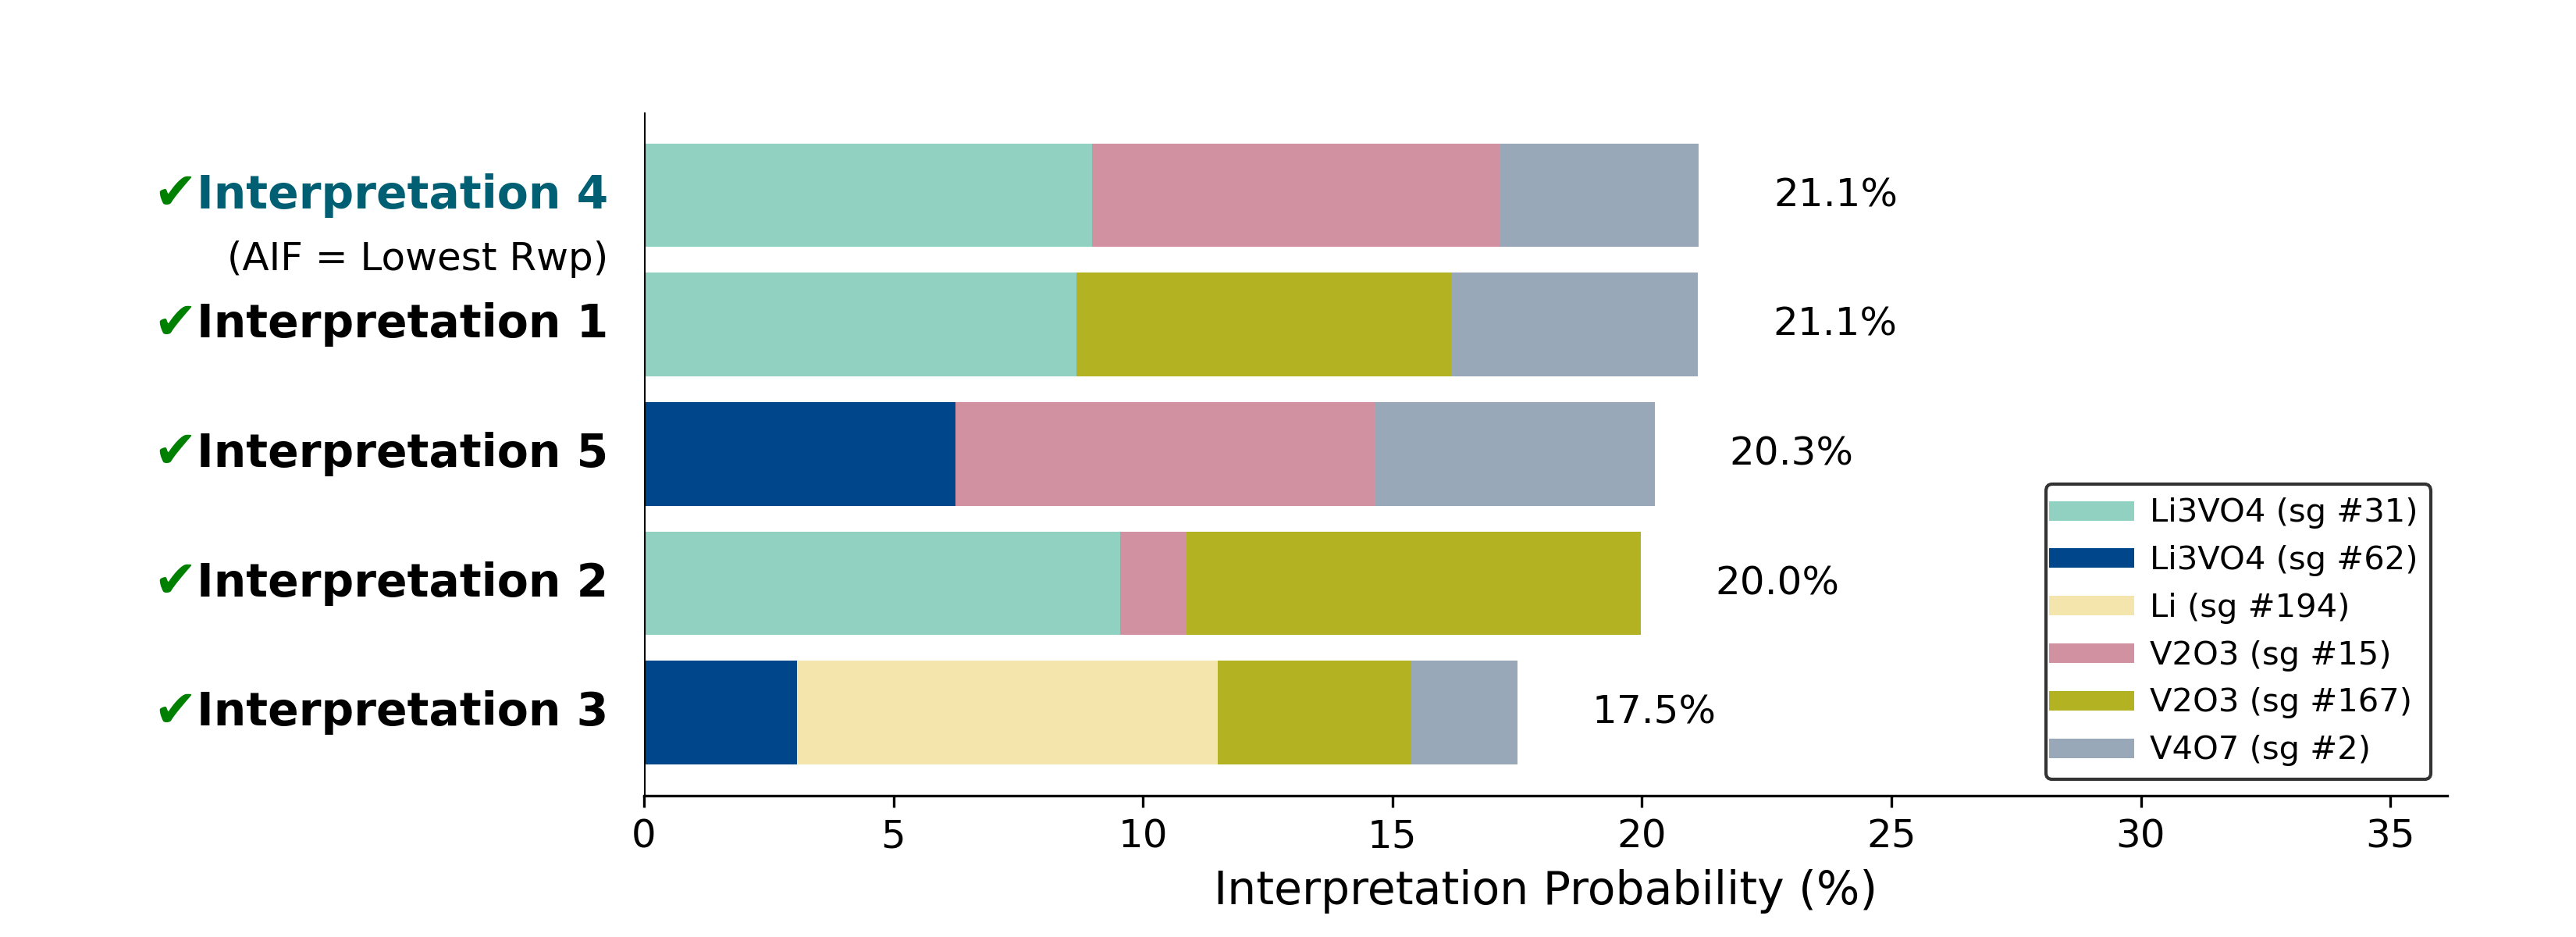


Phase probabilities (stacked by interpretation):


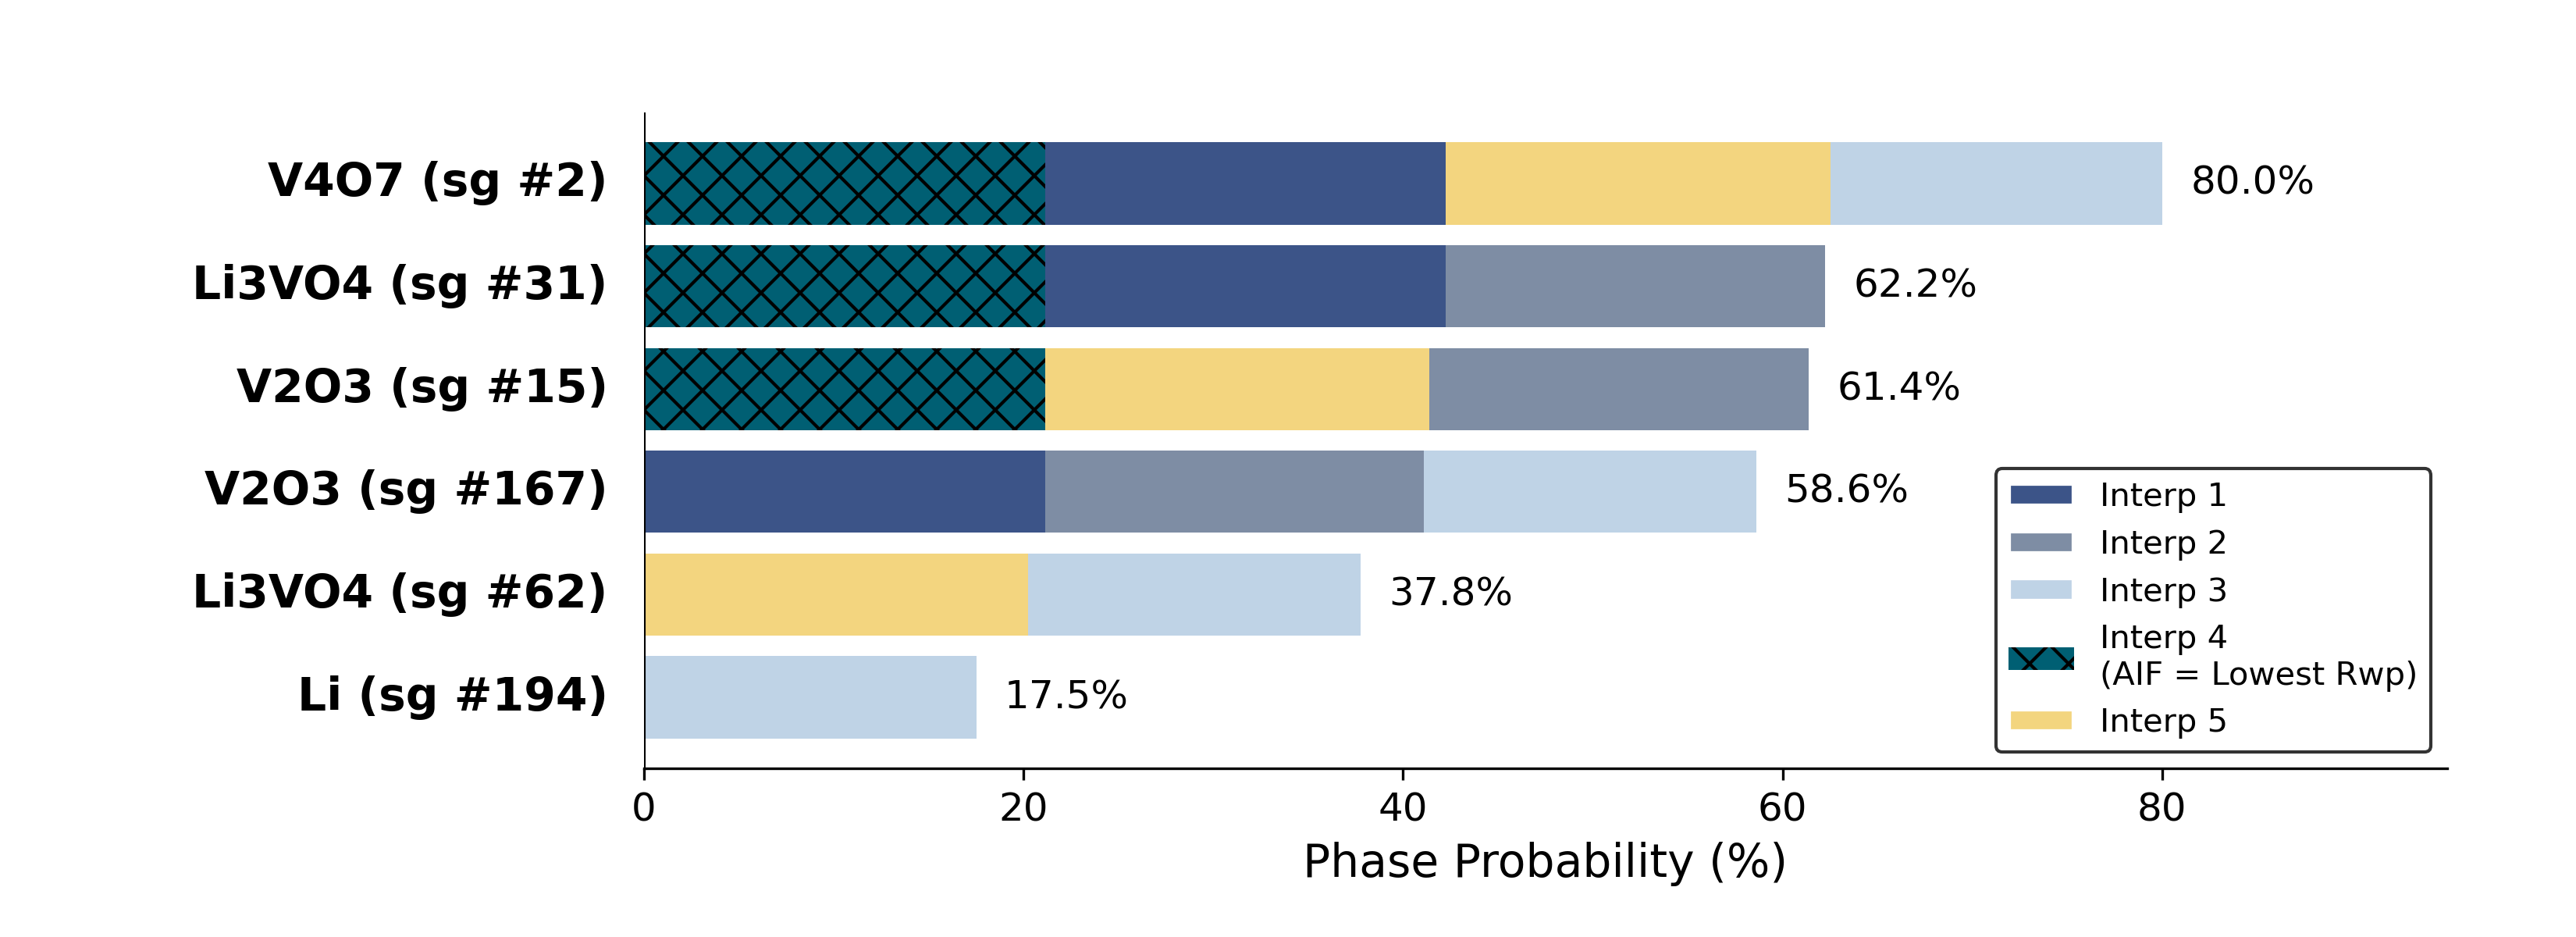


Metrics contribution (Rwp, score, balance, LLM):


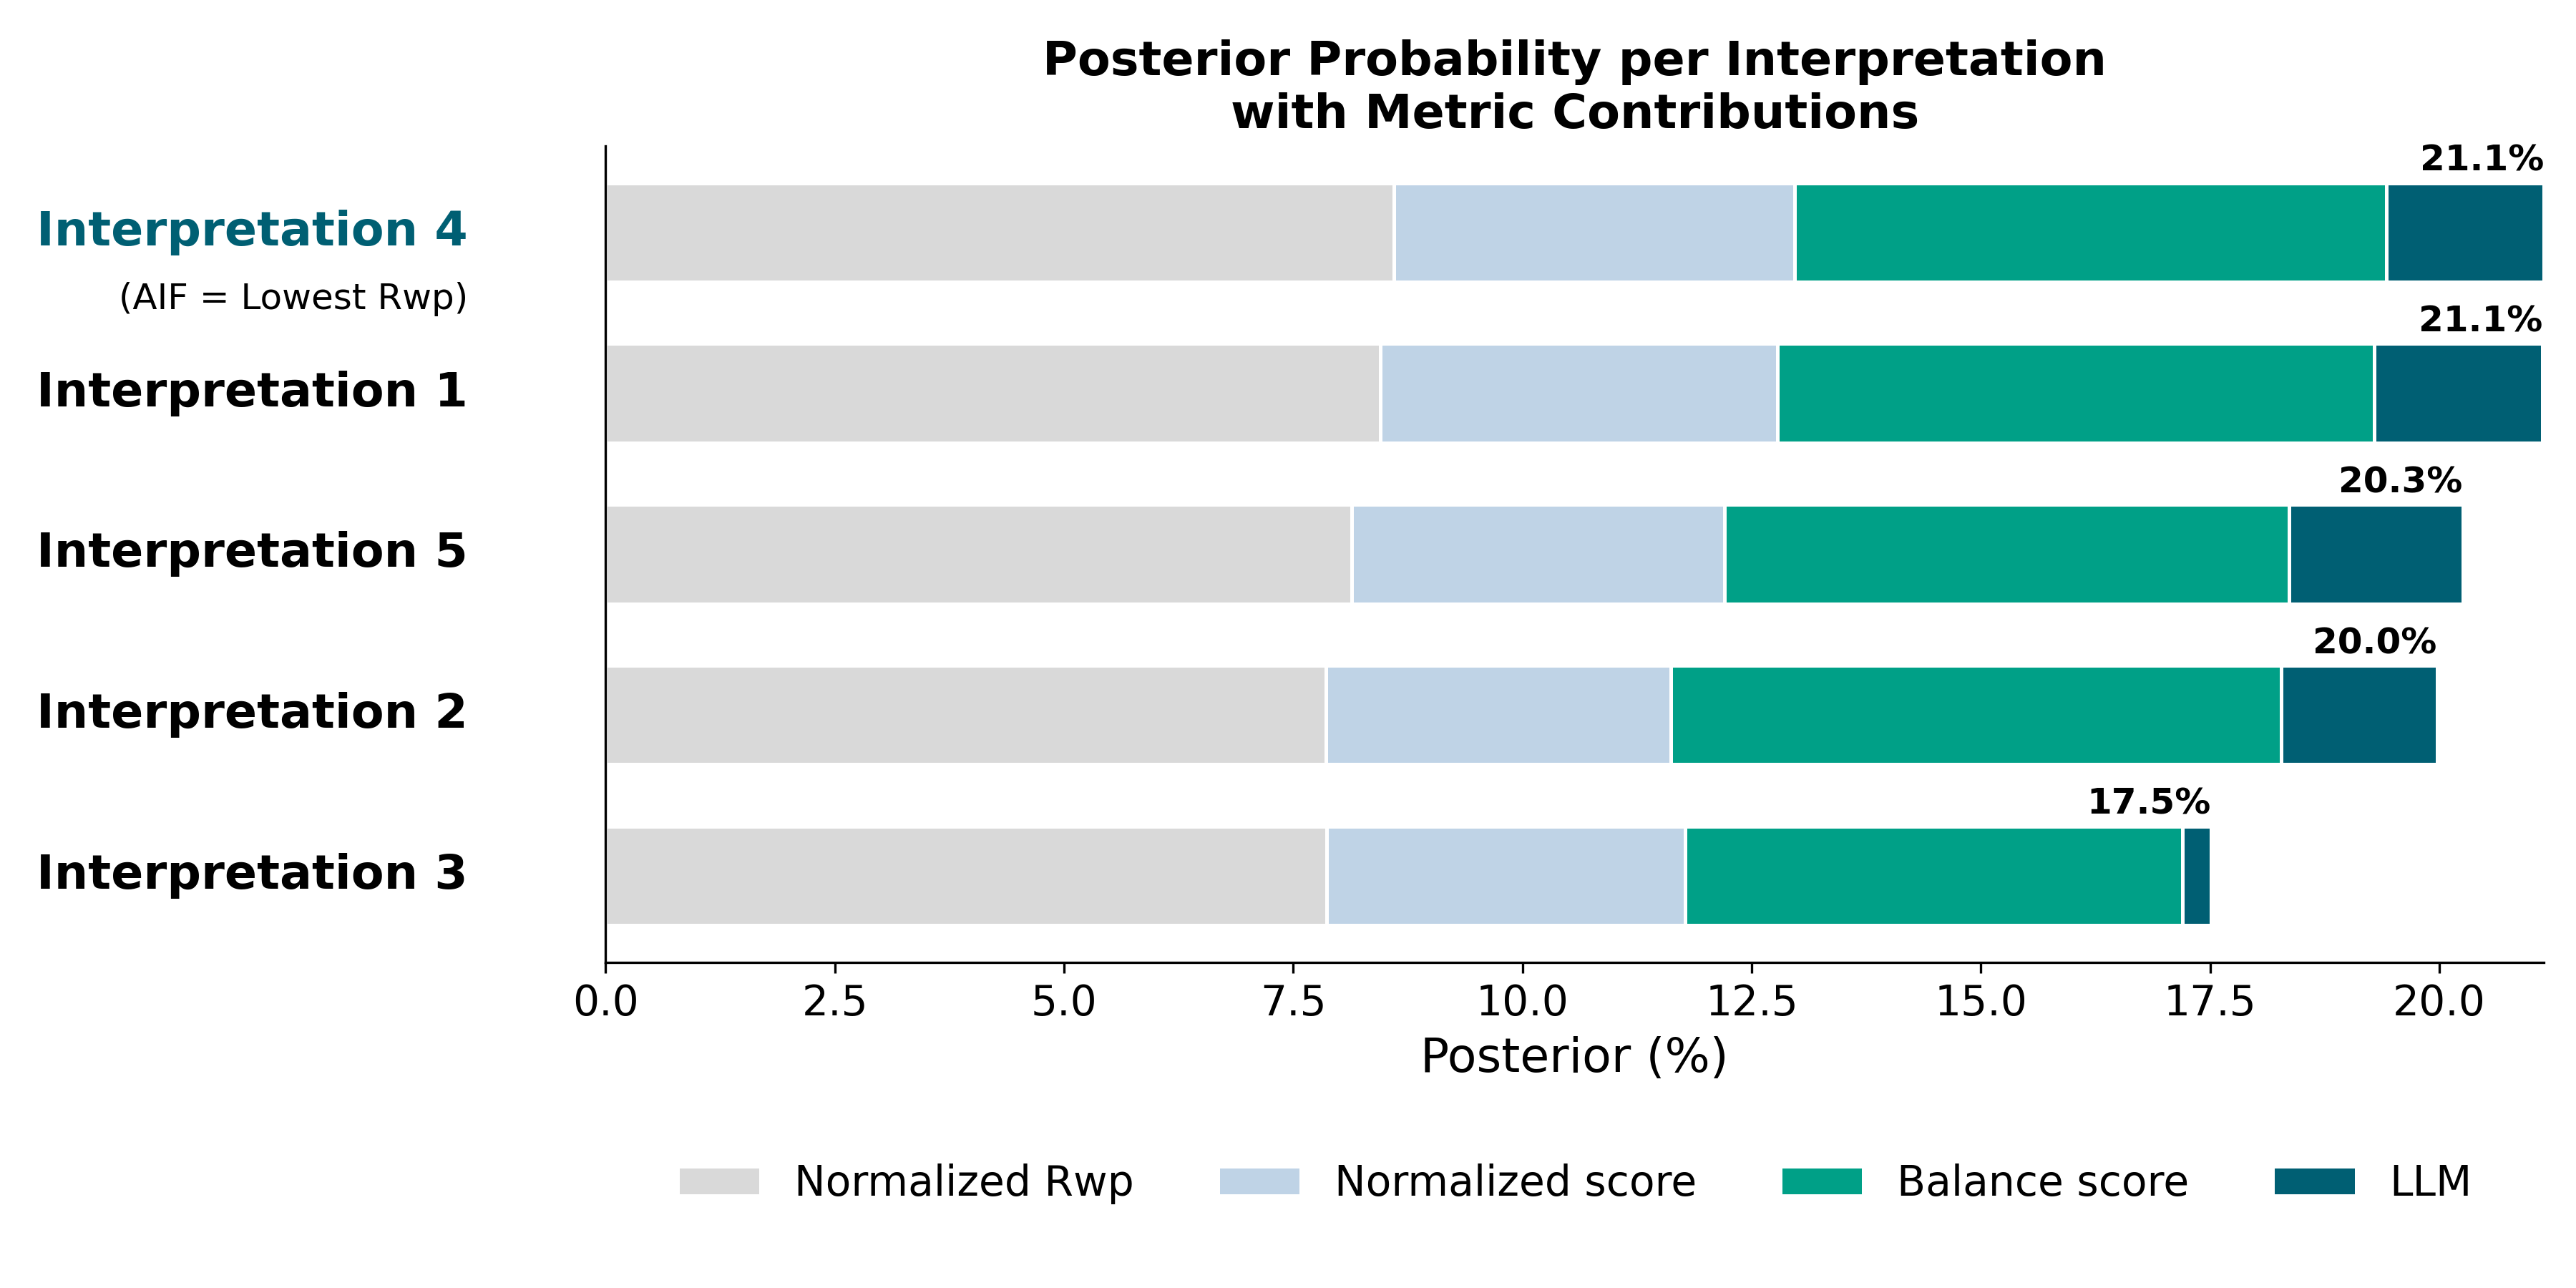

In [31]:
from IPython.display import Image, display

plot_dir = OUTPUT_DIR / "TRI" / target / SAMPLE_KEY

# Display interpretation probabilities and phase probabilities
interp_plot = plot_dir / "interpretation_probabilities.png"
phase_plot = plot_dir / "phases_probabilities.png"
metrics_plot = plot_dir / "metrics_contribution_breakdown.png"

if interp_plot.exists():
    print("Interpretation probabilities (stacked by phase):")
    display(Image(filename=str(interp_plot), width=700))
if phase_plot.exists():
    print("\nPhase probabilities (stacked by interpretation):")
    display(Image(filename=str(phase_plot), width=700))
if metrics_plot.exists():
    print("\nMetrics contribution (Rwp, score, balance, LLM):")
    display(Image(filename=str(metrics_plot), width=700))